# Preparation

In [1]:
import os
os.chdir("/home/jovyan/work")

# Control Task 3.2
Provide the given plots of a Beta Distribution

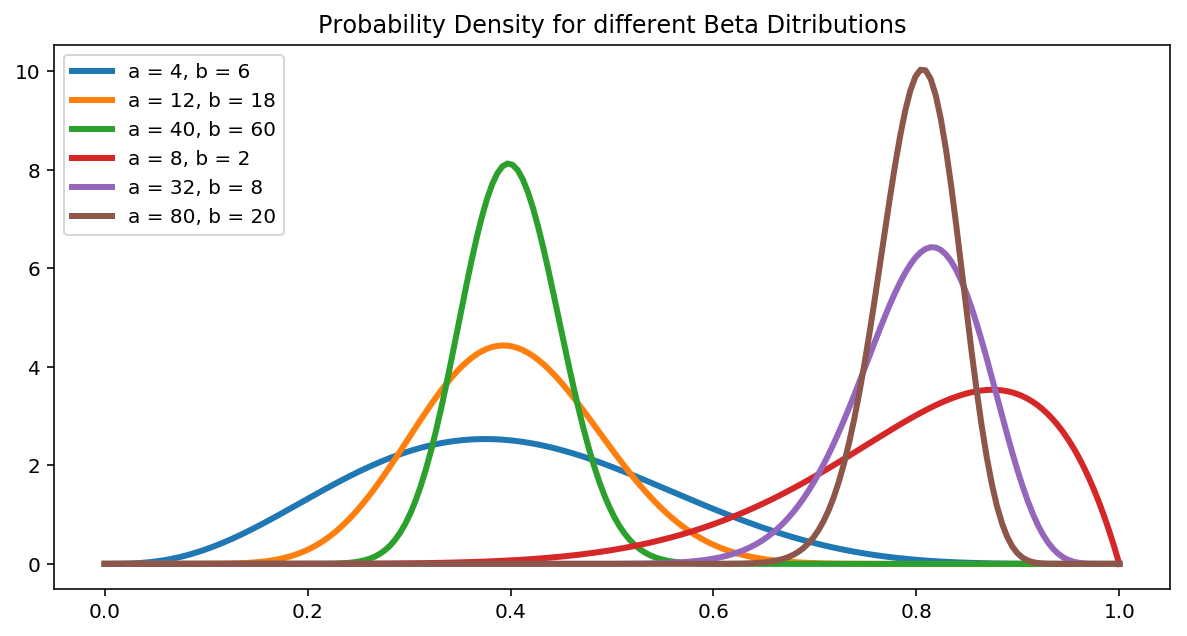

In [2]:
# %load src/3-02-beta-pdfs.py
# Imports
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# Config
os.chdir("/home/jovyan/work")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

# Prepare Distributions
alphas = [4, 12, 40, 8, 32, 80]
betas = [6, 18, 60, 2, 8, 20]

# Sample
x = np.linspace(0, 1, 200)

for a, b in zip(alphas, betas):
    plt.plot(
        x, 
        beta(a, b).pdf(x), 
        linewidth=3,
        label="a = {}, b = {}".format(a ,b)
    )
plt.legend(loc=0)
plt.title("Probability Density for different Beta Ditributions")
plt.savefig("./results/3-02-beta-pdfs.png")